In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
# load csv data into dask df
file_name = '../data/Crimes_-_2017.csv'
crimes = dd.read_csv(file_name, 
                 error_bad_lines=False,
                 assume_missing=True)

In [4]:
%%time
# log records count and load data partitions
print('{:,} total records in {} partitions'\
      .format(len(crimes), crimes.npartitions))

160,182 total records in 1 partitions
Wall time: 1.07 s


In [5]:
%%time
# drop duplicates
crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

Wall time: 9.77 ms


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
npartitions=1,,,,,,,,,,,,,,,,,,,,,,
None,float64,object,object,object,object,object,object,object,bool,bool,float64,float64,float64,float64,object,float64,float64,float64,object,float64,float64,object
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
%%time
# persist in memory
crimes = crimes.persist()

Wall time: 1.07 s


In [7]:
%%time
print("DataFrame size: {:,}".format(crimes.size.compute()))

DataFrame size: 3,524,004
Wall time: 4.88 ms


In [8]:
# get top 2 records
crimes.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,23507.0,JA385764,08/10/2017 04:04:00 PM,041XX S WALLACE ST,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,False,...,11.0,61.0,01A,1172991.0,1877172.0,2017.0,08/17/2017 03:54:34 PM,41.818390,-87.640922,"(41.818389748, -87.640921789)"
1,23506.0,JA384949,08/10/2017 02:22:00 AM,012XX N GREENVIEW AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,1.0,24.0,01A,1166164.0,1908438.0,2017.0,08/17/2017 03:54:34 PM,41.904335,-87.665073,"(41.904334636, -87.665072774)"


In [9]:
# get last 2 records
crimes.tail(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
160180,10802618.0,JA100607,01/01/2017 01:00:00 PM,003XX S HOYNE AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,2.0,28.0,06,NaN,NaN,2017.0,01/08/2017 03:48:20 PM,NaN,NaN,NaN
160181,10802303.0,JA101463,01/01/2017 07:00:00 PM,011XX E BOWEN AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,4.0,36.0,07,NaN,NaN,2017.0,01/08/2017 03:48:20 PM,NaN,NaN,NaN


In [10]:
# strip out white space from column names
crimes = crimes.rename(columns={c: c.replace(' ', '') for c in crimes.columns})
crimes.head(2)

,ID,CaseNumber,Date,Block,IUCR,PrimaryType,Description,LocationDescription,Arrest,Domestic,...,Ward,CommunityArea,FBICode,XCoordinate,YCoordinate,Year,UpdatedOn,Latitude,Longitude,Location
0,23507.0,JA385764,08/10/2017 04:04:00 PM,041XX S WALLACE ST,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,False,...,11.0,61.0,01A,1172991.0,1877172.0,2017.0,08/17/2017 03:54:34 PM,41.818390,-87.640922,"(41.818389748, -87.640921789)"
1,23506.0,JA384949,08/10/2017 02:22:00 AM,012XX N GREENVIEW AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,1.0,24.0,01A,1166164.0,1908438.0,2017.0,08/17/2017 03:54:34 PM,41.904335,-87.665073,"(41.904334636, -87.665072774)"


In [11]:
# list columns
crimes.columns

Index(['ID', 'CaseNumber', 'Date', 'Block', 'IUCR', 'PrimaryType',
       'Description', 'LocationDescription', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'CommunityArea', 'FBICode', 'XCoordinate',
       'YCoordinate', 'Year', 'UpdatedOn', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [12]:
# infer data types
crimes.dtypes

ID                     float64
CaseNumber              object
Date                    object
Block                   object
IUCR                    object
PrimaryType             object
Description             object
LocationDescription     object
Arrest                    bool
Domestic                  bool
Beat                   float64
District               float64
Ward                   float64
CommunityArea          float64
FBICode                 object
XCoordinate            float64
YCoordinate            float64
Year                   float64
UpdatedOn               object
Latitude               float64
Longitude              float64
Location                object
dtype: object

In [13]:
def unique_column_values(df):
    for column in df.columns:
        print("{} | {} | {}".format(
            df[column].name,
            len(df[column].unique()),
            df[column].dtype))

In [14]:
%%time
# print unique column values counts
print("Name | Unique # | Type")
unique_column_values(crimes)

Name | Unique # | Type
ID | 160182 | float64
CaseNumber | 160152 | object
Date | 70364 | object
Block | 24966 | object
IUCR | 314 | object
PrimaryType | 32 | object
Description | 293 | object
LocationDescription | 122 | object
Arrest | 2 | bool
Domestic | 2 | bool
Beat | 274 | float64
District | 23 | float64
Ward | 51 | float64
CommunityArea | 78 | float64
FBICode | 26 | object
XCoordinate | 43368 | float64
YCoordinate | 57212 | float64
Year | 1 | float64
UpdatedOn | 411 | object
Latitude | 87855 | float64
Longitude | 87848 | float64
Location | 87866 | object
Wall time: 1.5 s


In [15]:
# reduce data set
select_columns = ['Date', 'Block', 'PrimaryType','Description', 'LocationDescription', 
                  'Arrest', 'Domestic', 'Latitude', 'Longitude']

In [16]:
crimes = crimes[select_columns]
print("{:,} total records".format(len(crimes)))
crimes.head(2)

160,182 total records


,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
0,08/10/2017 04:04:00 PM,041XX S WALLACE ST,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,False,41.818390,-87.640922
1,08/10/2017 02:22:00 AM,012XX N GREENVIEW AVE,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,41.904335,-87.665073


In [17]:
# drop duplicates
crimes = crimes.drop_duplicates() #.dropna()
print("{:,} total records".format(len(crimes)))
crimes.head(2)

159,919 total records


,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
0,08/10/2017 04:04:00 PM,041XX S WALLACE ST,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,False,41.818390,-87.640922
1,08/10/2017 02:22:00 AM,012XX N GREENVIEW AVE,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,41.904335,-87.665073


In [18]:
# count arrests
arrests = crimes[crimes.Arrest==True]
print("{:,} arrests".format(len(arrests)))
arrests.head()

30,819 arrests


,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
0,08/10/2017 04:04:00 PM,041XX S WALLACE ST,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,False,41.818390,-87.640922
34,07/31/2017 08:30:00 PM,0000X S CICERO AVE,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,True,False,NaN,NaN
38,07/14/2017 07:51:00 PM,044XX W JACKSON BLVD,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,True,False,NaN,NaN
70,08/10/2017 09:09:00 PM,081XX W HIGGINS RD,PROSTITUTION,SOLICIT FOR BUSINESS,HOTEL/MOTEL,True,False,41.985421,-87.829757
146,08/10/2017 09:00:00 PM,055XX N KENMORE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,41.982517,-87.656584


In [19]:
# domestic violance
domestic = crimes[crimes.Domestic==True]
print("{:,} domestic crime reports".format(len(domestic)))
domestic.head()

26,261 domestic crime reports


,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
2,08/04/2017 09:00:00 PM,017XX N MASON AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,NaN,NaN
10,06/06/2017 08:32:00 AM,071XX S VINCENNES AVE,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,True,NaN,NaN
11,07/25/2017 03:00:00 PM,064XX S DR MARTIN LUTHER KING JR DR,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,True,NaN,NaN
18,08/08/2017 11:00:00 PM,059XX S TROY ST,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,NaN,NaN
36,08/02/2017 09:30:00 PM,001XX S HALSTED ST,BATTERY,DOMESTIC BATTERY SIMPLE,OTHER,False,True,NaN,NaN


In [20]:
crimes.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 9 entries, Date to Longitude
dtypes: object(5), bool(2), float64(2)

In [21]:
# get narcotics crimes
narcotics = crimes[crimes['PrimaryType']=='NARCOTICS']
narcotics = narcotics.set_index('Date')
narcotics.head()

,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,
01/01/2017 01:31:00 PM,077XX S UNION AVE,NARCOTICS,MANU/DELIVER:CRACK,RESIDENCE,True,False,41.753552,-87.641674
01/01/2017 01:58:00 PM,050XX W CHICAGO AVE,NARCOTICS,MANU/DELIVER: HALLUCINOGEN,TAVERN/LIQUOR STORE,True,False,NaN,NaN
01/01/2017 02:12:00 PM,083XX S COTTAGE GROVE AVE,NARCOTICS,POSS: CRACK,GAS STATION,True,False,41.743504,-87.605018
01/01/2017 02:24:00 PM,010XX N RIDGEWAY AVE,NARCOTICS,POSS: HEROIN(WHITE),SIDEWALK,True,False,41.900070,-87.720124
01/01/2017 03:19:00 AM,055XX W WASHINGTON BLVD,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,41.882252,-87.764442


In [22]:
# get narcotics crime description counts
narcotics_crimes = narcotics[['PrimaryType', 'Description']]\
.groupby('Description').count().compute()\
.sort_values(by='PrimaryType', ascending=False)

print(narcotics_crimes.head(10))
print('...')
print('Total Narcotics Crime Descriptions: {}'.format(len(narcotics_crimes)))

                                PrimaryType
Description                                
POSS: HEROIN(WHITE)                    1303
POSS: CANNABIS 30GMS OR LESS            759
POSS: CRACK                             632
MANU/DELIVER: HEROIN (WHITE)            571
FOUND SUSPECT NARCOTICS                 466
MANU/DEL:CANNABIS 10GM OR LESS          398
POSS: CANNABIS MORE THAN 30GMS          360
MANU/DEL:CANNABIS OVER 10 GMS           359
POSS: COCAINE                           291
MANU/DELIVER:CRACK                      240
...
Total Narcotics Crime Descriptions: 40


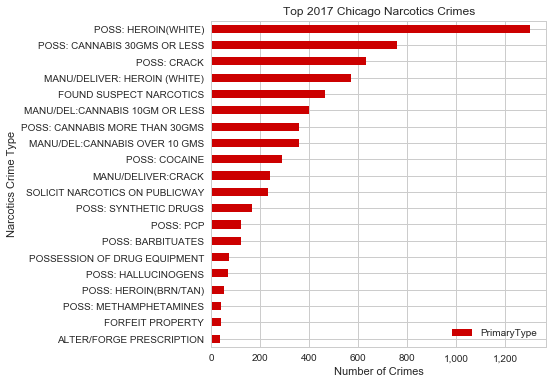

In [25]:
# plot top 20 narcotics crimes
narcotics_crimes[:20].sort_values(by='PrimaryType', ascending=True)\
.plot(kind='barh', figsize=(6,6), color='#cc0000')
plt.title('Top 2017 Chicago Narcotics Crimes')
plt.xlabel('Number of Crimes')
plt.ylabel('Narcotics Crime Type')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [26]:
# get other offenses crimes
other_offenses = crimes[crimes['PrimaryType']=='OTHER OFFENSE']
other_offenses = other_offenses.set_index('Date')
other_offenses.head()

,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,
01/01/2017 01:00:00 AM,056XX S MAYFIELD AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,NaN,NaN
01/01/2017 01:00:00 AM,019XX N HAMLIN AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,41.916211,-87.721638
01/01/2017 01:00:00 PM,021XX W ARMITAGE AVE,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,OTHER,False,True,41.917689,-87.680898
01/01/2017 01:00:00 PM,023XX W 115TH ST,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,41.684460,-87.679939
01/01/2017 01:10:00 AM,075XX S DAMEN AVE,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,41.757026,-87.673325


In [28]:
# get other offense crime description counts
other_offense_crimes = other_offenses[['PrimaryType', 'Description']]\
.groupby('Description').count().compute()\
.sort_values(by='PrimaryType', ascending=False)

print(other_offense_crimes.head(10))
print('...')
print('Total Other Offense Crime Descriptions: {}'.format(len(other_offense_crimes)))

                                PrimaryType
Description                                
TELEPHONE THREAT                       2467
HARASSMENT BY TELEPHONE                1735
HARASSMENT BY ELECTRONIC MEANS         1656
VIOLATE ORDER OF PROTECTION             998
OTHER VEHICLE OFFENSE                   878
PAROLE VIOLATION                        577
FALSE/STOLEN/ALTERED TRP                542
VEHICLE TITLE/REG OFFENSE               399
LICENSE VIOLATION                       310
OTHER CRIME AGAINST PERSON              243
...
Total Other Offense Crime Descriptions: 41


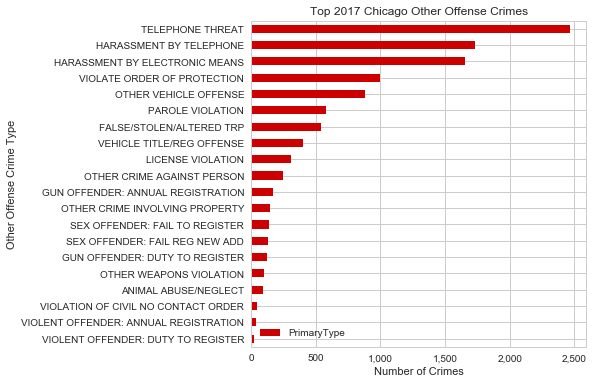

In [31]:
# plot top 20 other offense crimes
other_offense_crimes[:20].sort_values(by='PrimaryType', ascending=True)\
.plot(kind='barh', figsize=(6,6), color='#cc0000')
plt.title('Top 2017 Chicago Other Offense Crimes')
plt.xlabel('Number of Crimes')
plt.ylabel('Other Offense Crime Type')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()